In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.filter import sigmasq
from pycbc import waveform
from calcwf import chirp2total, gen_wf, ceiltwo, gen_psd, shifted_e
from scipy.optimize import minimize
import os
import pickle

In [28]:
e_params = [0.05, 0.1, 0.2]
chirp_params = [10, 24, 50]
e_vals_10 = [np.linspace(0, 0.2, 31), np.linspace(0, 0.2, 31), np.linspace(0, 0.3, 31)]
chirp_vals_10 = [np.linspace(9.9, 10.1, 31), np.linspace(23, 25, 31), np.linspace(44, 56, 31)]

In [29]:
def favata_et_al_freq(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1+(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1+(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_amp(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1-(157/48)*given_e**2)**(6/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1-(157/48)*e_vals**2)**(6/5)

    return chirp_vals

def favata_et_al_phase(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd, _ = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssf/ss)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

Average frequency: 30.373034352927448 Hz
Given_e shifted from 0.05 to 0.015476648673189592
Average frequency: 29.742315325971543 Hz
Given_e shifted from 0.05 to 0.015823284333524375
Average frequency: 29.76141254418651 Hz
Given_e shifted from 0.05 to 0.015812567004694845
Average frequency: 30.389699600612165 Hz
Given_e shifted from 0.1 to 0.03093538028570766
Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
Average frequency: 29.619140972966626 Hz
Given_e shifted from 0.1 to 0.031785501744115596
Average frequency: 30.565837246083582 Hz
Given_e shifted from 0.2 to 0.06149447913708912
Average frequency: 29.891279629579635 Hz
Given_e shifted from 0.2 to 0.06296023625430945
Average frequency: 29.687539494479257 Hz
Given_e shifted from 0.2 to 0.0634164122566784


Text(0.5, 0.92, 'quad, q=2, favata et al. line')

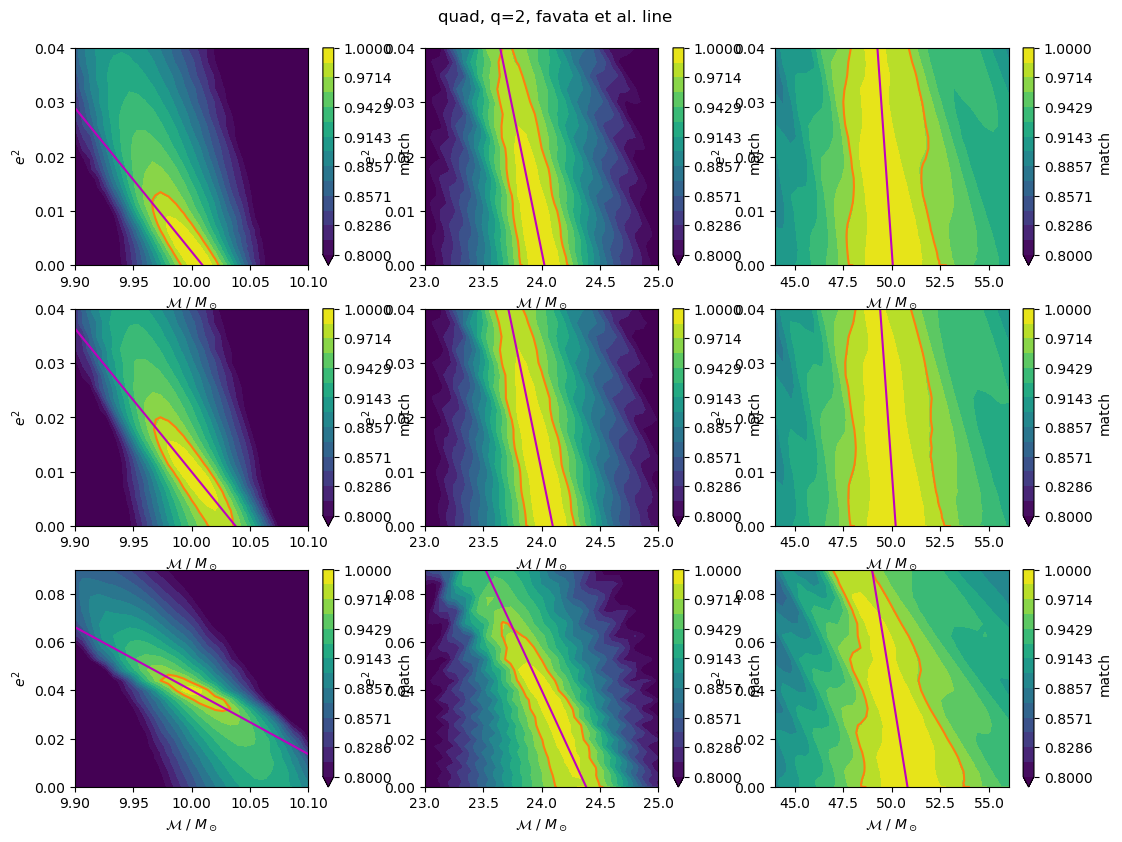

In [30]:
# Load data
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_10'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.subplot(len(e_params), len(chirp_params), i*3+j+1)
        plt.contourf(chirp_vals_10[j], e_vals_10[i]**2, data[i][j]['quad'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
        plt.colorbar(label='match')
        plt.contour(chirp_vals_10[j], e_vals_10[i]**2, data[i][j]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(e_params[i], chirp_params[j], e_vals_10[i]), e_vals_10[i]**2, c='m')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('quad, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 30.373034352927448 Hz
Given_e shifted from 0.05 to 0.015476648673189592
Average frequency: 29.742315325971543 Hz
Given_e shifted from 0.05 to 0.015823284333524375
Average frequency: 29.76141254418651 Hz
Given_e shifted from 0.05 to 0.015812567004694845
Average frequency: 30.389699600612165 Hz
Given_e shifted from 0.1 to 0.03093538028570766
Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
Average frequency: 29.619140972966626 Hz
Given_e shifted from 0.1 to 0.031785501744115596
Average frequency: 30.565837246083582 Hz
Given_e shifted from 0.2 to 0.06149447913708912
Average frequency: 29.891279629579635 Hz
Given_e shifted from 0.2 to 0.06296023625430945
Average frequency: 29.687539494479257 Hz
Given_e shifted from 0.2 to 0.0634164122566784


Text(0.5, 0.92, 'quad, q=2, favata et al. line')

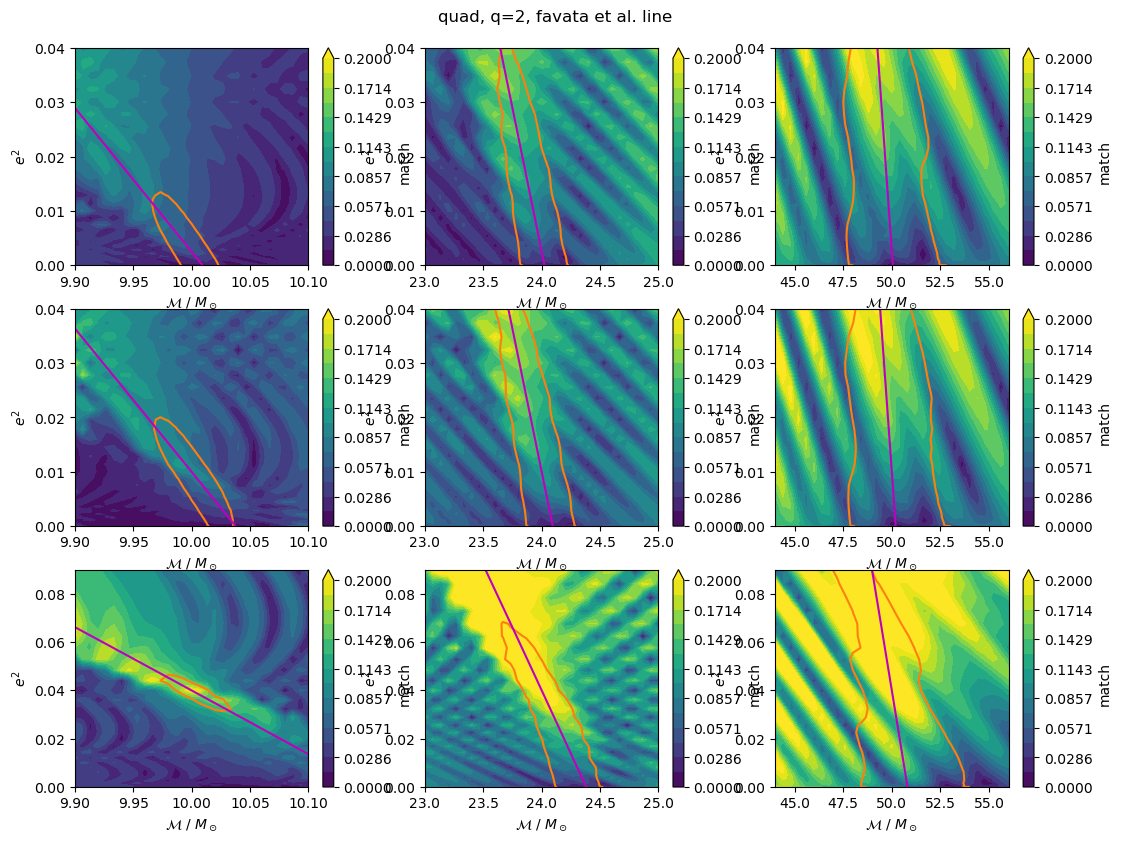

In [31]:
# Load data
with open(os.path.join('e_sqrd_chirp_data', 'dataslot_10'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.subplot(len(e_params), len(chirp_params), i*3+j+1)
        plt.contourf(chirp_vals_10[j], e_vals_10[i]**2, np.array(data[i][j]['h2'])/np.array(data[i][j]['h1']), np.linspace(0, 0.2, 15), vmin=0, vmax=0.2, extend='max')
        plt.colorbar(label='match')
        plt.contour(chirp_vals_10[j], e_vals_10[i]**2, data[i][j]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(e_params[i], chirp_params[j], e_vals_10[i]), e_vals_10[i]**2, c='m')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('quad, q=2, favata et al. line', x=0.5, y=0.92)